In [9]:
import requests
from PIL import Image
import torch

from transformers import Owlv2Processor, Owlv2ForObjectDetection

processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")


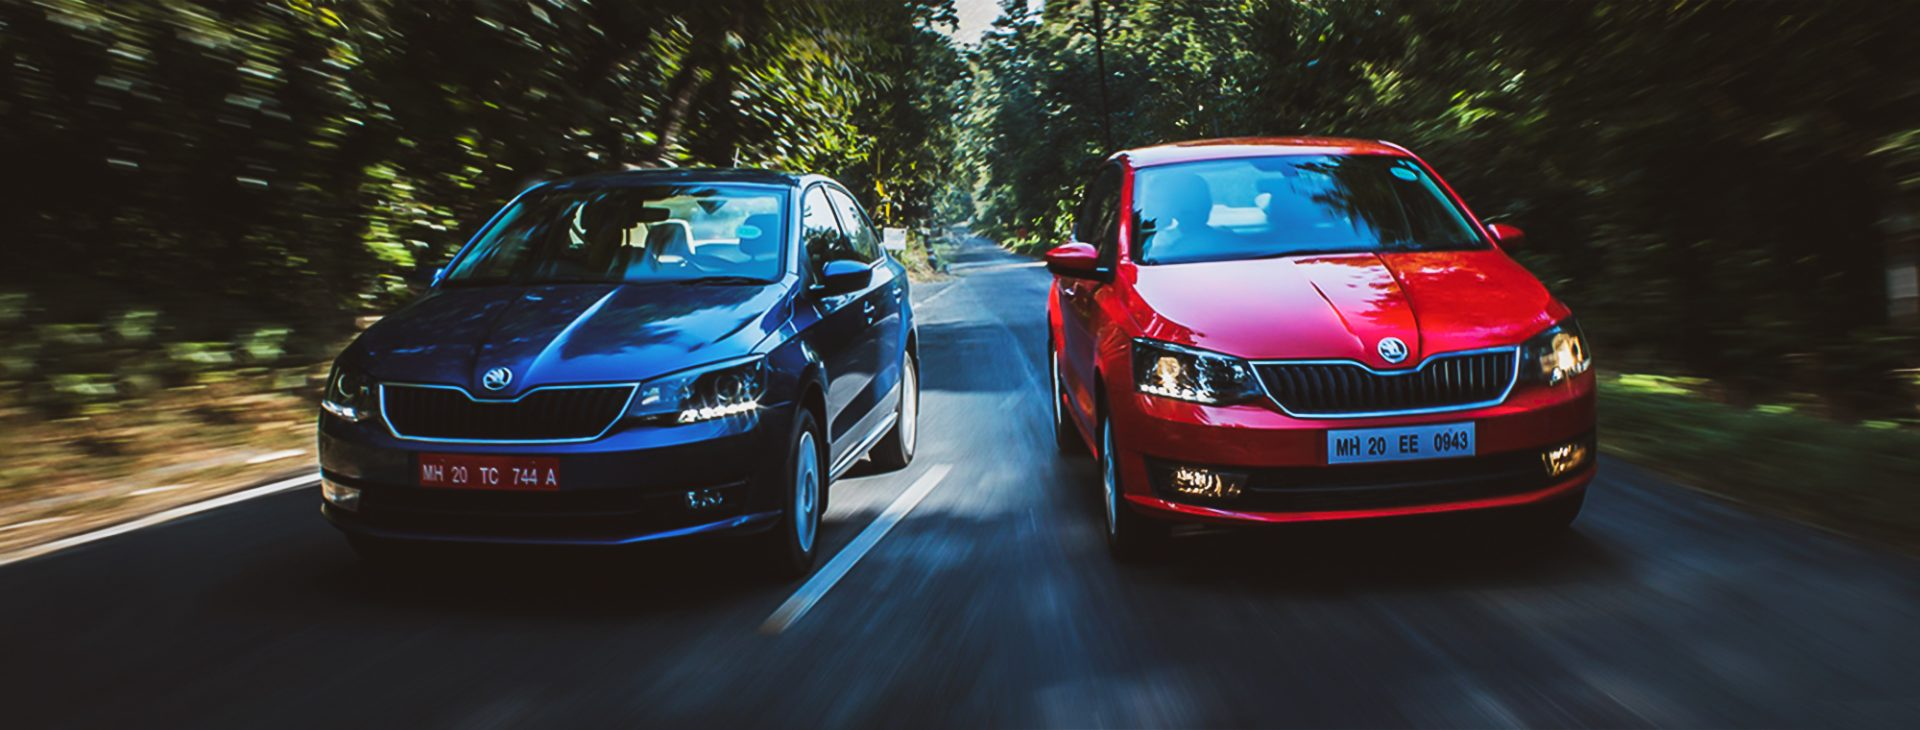

In [10]:
from PIL import Image
import requests

url = '/content/Cars.jpg'
image = Image.open(url)
image

In [11]:
texts = [['number plate']]
inputs = processor(text=texts, images=image, return_tensors="pt")
for k,v in inputs.items():
  print(k,v.shape)

input_ids torch.Size([2, 16])
attention_mask torch.Size([2, 16])
pixel_values torch.Size([1, 3, 960, 960])


In [12]:
import torch

with torch.no_grad():
  outputs = model(**inputs)

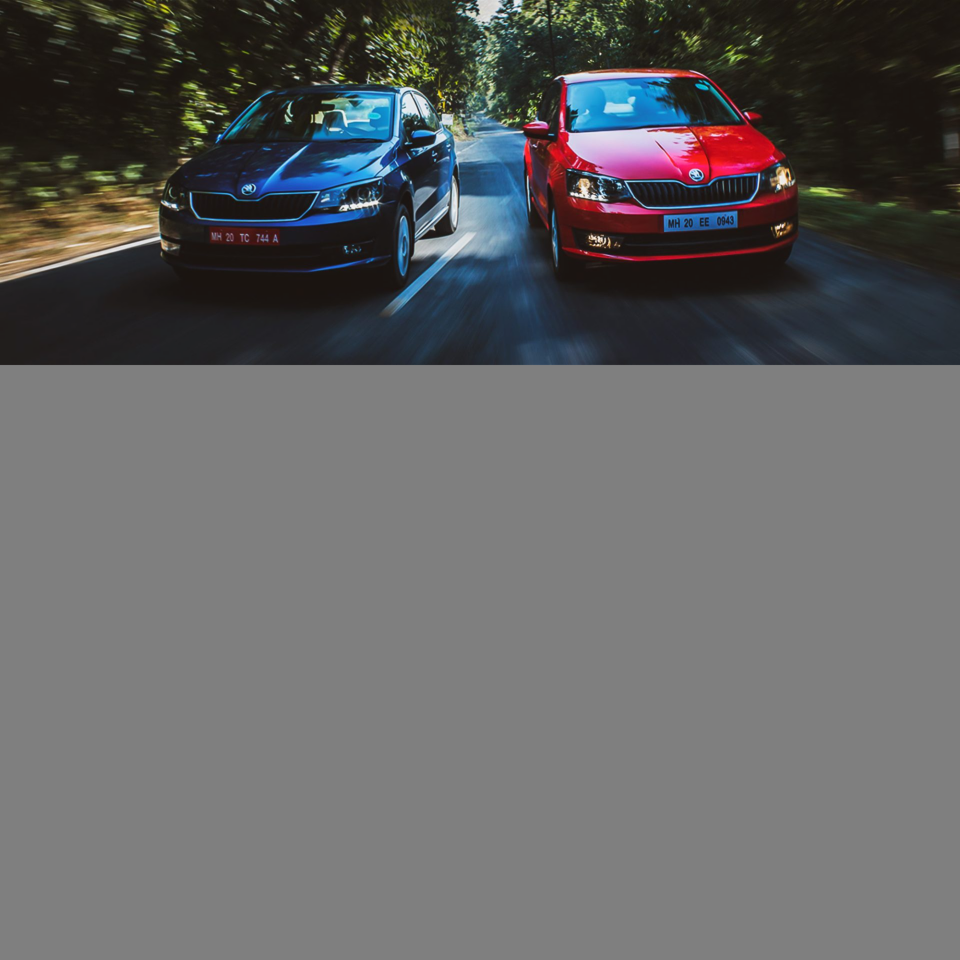

In [13]:
import numpy as np
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

def get_preprocessed_image(pixel_values):
    pixel_values = pixel_values.squeeze().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

unnormalized_image = get_preprocessed_image(inputs.pixel_values)
unnormalized_image

In [14]:

target_sizes = torch.Tensor([unnormalized_image.size[::-1]])
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.2)
i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected number plate with confidence 0.524 at location [664.1, 211.58, 740.23, 232.22]
Detected number plate with confidence 0.557 at location [208.25, 228.72, 283.71, 245.48]


In [26]:
!pip install paddleocr
!pip install paddlepaddle
from matplotlib import pyplot as plt
import cv2
import os
from paddleocr import PaddleOCR, draw_ocr

In [27]:
from PIL import ImageDraw

visualized_image = unnormalized_image.copy()

draw = ImageDraw.Draw(visualized_image)
images = []
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    x1, y1, x2, y2 = tuple(box)

    cropped_image = visualized_image.crop((x1, y1, x2, y2))
    ocr = PaddleOCR(use_angle_cls=True, lang='en')

    if isinstance(cropped_image, np.ndarray):
        cropped_image = Image.fromarray(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

    result = ocr.ocr(np.array(cropped_image), cls=True)

    for line in result:
        for word_info in line:
            points = word_info[0]
            text = word_info[1][0]
            print(f"LICENSE PLATE: {text}")


[2024/06/23 12:10:05] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='